In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DSMLProjectNew/data.zip

In [9]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory

data_head_dir = Path('/content/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [10]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

Loading and pre processing the data

In [26]:
!pip install tensorflow
import random
import tensorflow as tf
from PIL import Image

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        # Normalize the image to the [0, 1] range
        # img = img / 255.0


        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])  # Scalar label

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size,  drop_remainder=True)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=False).batch(batch_size, drop_remainder=True)

In [27]:
print("Size of train data - ", len(tf_dataset_train))
print("Size of train data - ", len(tf_dataset_val))
print("Size of train data - ", len(tf_dataset_test))

Size of train data -  927
Size of train data -  352
Size of train data -  400


In [13]:
# Printing the tensors in the training dataset - First batch
print(np.shape(tf_dataset_train))
for img, label in tf_dataset_train.take(1):
    print("Tensors in train data")
    print("Image Tensor1:")
    print(img.numpy())  # Converting the image tensor to NumPy array
    print("\nLabel Tensor1:")
    print(label.numpy())  # Convert the label tensor to NumPy array

# Printing the tensors in the validation dataset - First batch
for img, label in tf_dataset_val.take(1):
    print("Tensors in val data")
    print("Image Tensor2:")
    print(img.numpy())
    print("\nLabel Tensor2:")
    print(label.numpy())

# Printing the tensors in the test dataset - First batch
for img, label in tf_dataset_test.take(1):
    print("Tensors in test data")
    print("Image Tensor3:")
    print(img.numpy())
    print("\nLabel Tensor3:")
    print(label.numpy())


()
Tensors in train data
Image Tensor1:
[[[[ 68.  68.  68.]
   [ 68.  68.  68.]
   [ 67.  67.  67.]
   ...
   [ 84.  84.  84.]
   [ 85.  85.  85.]
   [ 85.  85.  85.]]

  [[ 68.  68.  68.]
   [ 68.  68.  68.]
   [ 67.  67.  67.]
   ...
   [ 84.  84.  84.]
   [ 85.  85.  85.]
   [ 85.  85.  85.]]

  [[ 65.  65.  65.]
   [ 65.  65.  65.]
   [ 65.  65.  65.]
   ...
   [ 83.  83.  83.]
   [ 82.  82.  82.]
   [ 82.  82.  82.]]

  ...

  [[ 80.  80.  80.]
   [ 80.  80.  80.]
   [ 80.  80.  80.]
   ...
   [ 77.  77.  77.]
   [ 78.  78.  78.]
   [ 78.  78.  78.]]

  [[ 86.  86.  86.]
   [ 86.  86.  86.]
   [ 86.  86.  86.]
   ...
   [ 86.  86.  86.]
   [ 85.  85.  85.]
   [ 85.  85.  85.]]

  [[ 86.  86.  86.]
   [ 86.  86.  86.]
   [ 86.  86.  86.]
   ...
   [ 86.  86.  86.]
   [ 85.  85.  85.]
   [ 85.  85.  85.]]]


 [[[141. 141. 141.]
   [147. 147. 147.]
   [140. 140. 140.]
   ...
   [135. 135. 135.]
   [131. 131. 131.]
   [115. 115. 115.]]

  [[144. 144. 144.]
   [148. 148. 148.]
   [143.

Training CNN + MLP


Performed empirical regularization, crop, randomly zoom, rotate, flip, con-trast, and translate images in your training set for image augmentation

In [10]:
!pip install opencv-python

In [28]:
import cv2
import numpy as np
import os

def augment_data(image, label):
    # Applying transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_brightness(image, max_delta=0.2)


    # Cropping and resizing back to original size
    image = tf.image.random_crop(image, size=[32, *IMAGE_SIZE, 3])
    image = tf.image.resize(image, (299,299))


    # Random translation
    image = tf.image.pad_to_bounding_box(image, offset_height=20, offset_width=20, target_height=IMAGE_SIZE[0] + 40, target_width=IMAGE_SIZE[1] + 40)

    # Random zoom
    scale = tf.random.uniform([], 0.8, 1.2)
    h, w = IMAGE_SIZE[0], IMAGE_SIZE[1]
    new_height, new_width = h * scale, w * scale
    image = tf.image.resize(image, [int(new_height), int(new_width)])
    image = tf.image.resize_with_crop_or_pad(image, h, w)

    return image, label


def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=2)  # Assuming 2 classes
    return image, label


# Apply augmentation to each image in the dataset
tf_dataset_train_augmented = tf_dataset_train.map(augment_data)

tf_data_train_one_hot_encoded = tf_dataset_train.map(one_hot_encode)
tf_data_train_augmeted_one_hot_encoded = tf_dataset_train_augmented.map(one_hot_encode)
tf_data_test_one_hot_encoded = tf_dataset_test.map(one_hot_encode)
tf_data_val_one_hot_encoded = tf_dataset_val.map(one_hot_encode)

# Concatenating the datasets one after the other and shuffling
tf_data_combined_one_hot_encoded = tf.data.Dataset.concatenate(tf_data_train_one_hot_encoded, tf_data_train_augmeted_one_hot_encoded)

tf_data_combined_one_hot_encoded_shuffled = tf_data_combined_one_hot_encoded.shuffle(buffer_size=64)
# Take one batch for demonstration
for img, label in tf_data_train_augmeted_one_hot_encoded.take(1):
    # Convert the image and label tensors to NumPy arrays and print
    image_array = img.numpy()
    label_array = label.numpy()

    # Print the image tensor
    print("Augmented Image Tensor:")
    print(image_array)

    # Print the label tensor
    print("\nAugmented Label Tensor:")
    print(label_array)
len(tf_data_combined_one_hot_encoded)


Augmented Image Tensor:
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
  

1854

In [29]:
y_test_list = []


for _, label in tf_data_test_one_hot_encoded:
    for a in label.numpy():
        y_test_list.append(a)
y_test = np.argmax(y_test_list, axis=1)

In [30]:
print(len(y_test))

12800


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(299, 299, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense (fully connected) layer
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.3))  # 30% dropout

# Output layer
model.add(layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history = model.fit(tf_data_combined_one_hot_encoded_shuffled, epochs=22, validation_data=tf_data_val_one_hot_encoded, callbacks=[early_stopping, model_checkpoint])

model.save_weights('/content/drive/MyDrive/DSML/saved_model_weights_final.h5')


Epoch 1/22
1854/1854 [==============================] - ETA: 0s - loss: 7.8098 - accuracy: 0.6394

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1854/1854 [==============================] - 801s 424ms/step - loss: 7.8098 - accuracy: 0.6394 - val_loss: 2.3691 - val_accuracy: 0.7467
Epoch 2/22
1854/1854 [==============================] - 775s 412ms/step - loss: 1.9915 - accuracy: 0.6479 - val_loss: 1.2255 - val_accuracy: 0.8151
Epoch 3/22
1854/1854 [==============================] - 775s 411ms/step - loss: 1.1241 - accuracy: 0.6925 - val_loss: 1.2288 - val_accuracy: 0.3850
Epoch 4/22
1854/1854 [==============================] - 773s 410ms/step - loss: 0.7438 - accuracy: 0.7583 - val_loss: 1.1830 - val_accuracy: 0.3024
Epoch 5/22
1854/1854 [==============================] - 796s 423ms/step - loss: 0.6922 - accuracy: 0.7737 - val_loss: 1.1790 - val_accuracy: 0.3729
Epoch 6/22
1854/1854 [==============================] - 789s 419ms/step - loss: 0.6070 - accuracy: 0.8250 - val_loss: 0.9711 - val_accuracy: 0.3940
Epoch 7/22
1854/1854 [==============================] - 779s 414ms/step - loss: 0.5542 - accuracy: 0.8428 - val_loss: 0.827

plotting training and validation loss


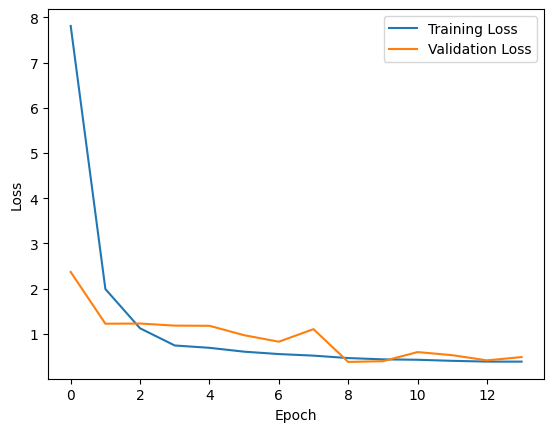

In [21]:
# Plot training and validation loss
print("plotting training and validation loss")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plotting training and validation accuracy


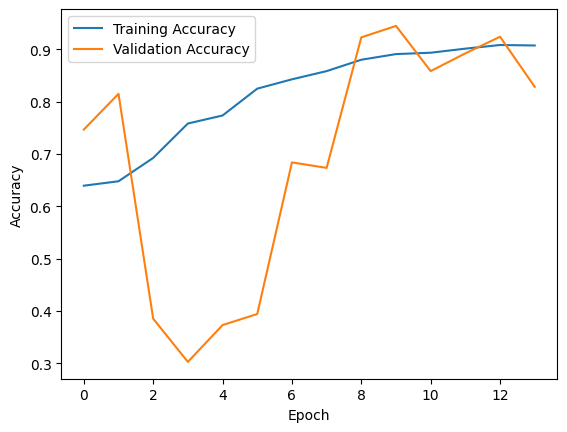

In [22]:
# Plot training and validation accuracy
print("plotting training and validation accuracy")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

training and validation errors


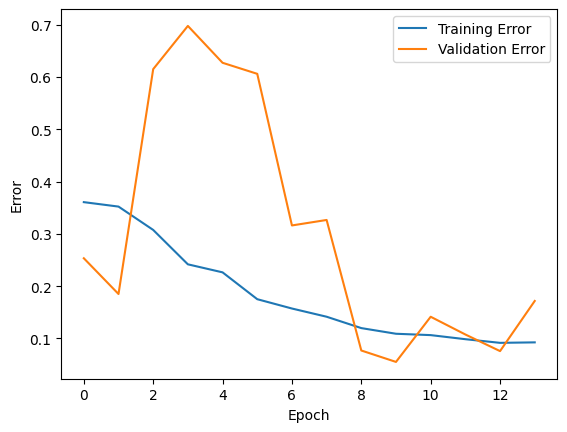

In [25]:
# Plot training and validation errors (1 - accuracy) over epochs# Plot training and validation errors (1 - accuracy) over epochs
print("training and validation errors")
plt.plot([1 - acc for acc in history.history['accuracy']], label='Training Error')
plt.plot([1 - acc for acc in history.history['val_accuracy']], label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [31]:
import numpy as np
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(tf_dataset_test)

400/400 [==============================] - 78s 192ms/step


In [32]:
y_pred = np.argmax(y_pred, axis=1)

In [33]:
print(len(y_test))
print(len(y_pred))

12800
12800


In [34]:
# Classification report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.98      0.81      4408
           1       0.99      0.77      0.86      8392

    accuracy                           0.84     12800
   macro avg       0.84      0.88      0.84     12800
weighted avg       0.89      0.84      0.85     12800



We get an accuracy of 84% on the test dataset

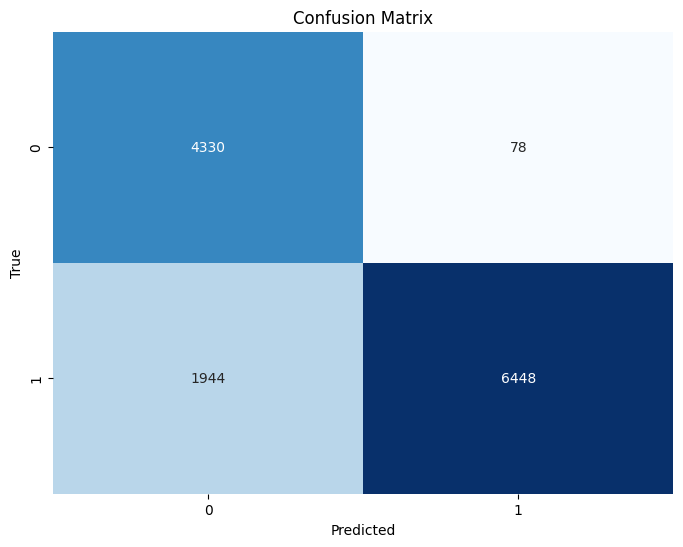

In [37]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()